<a href="https://colab.research.google.com/github/viraatdas/Purdue_CompVis_Workshop/blob/12_end_predict/speed_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
print("wus good")

wus good


Import video files

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Import libraries

In [0]:
import os
import csv
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Organize file paths

In [0]:
train_video = "./drive/My Drive/speed_predict/train.mp4"
labels = "./drive/My Drive/speed_predict/train.txt"
output_path = "./drive/My Drive/speed_predict/data_preprocessed"
FRAME_RATE = 20

if not os.path.exists(output_path):
  os.mkdir(output_path)
  print(f"Directory {output_path} created")

PreProcessor Class

In [0]:
class PreProcessor():
  def __str__(self):
    # indicate class description
    return "Pre-processor class"
  def grayscale(self, frame):
    # converts frame to gray scale
    return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  
  def plot_training_speed(self, data):
    # plot labels
    data = np.loadtxt(data)
    plt.plot(data)
    plt.show()
  def generate_images(self, file_path, label_path, gray=False):
    # Takes the video file and generates images for each
    # of it's frames. The time for each frame and the image path
    # for the corresponding frame is stored in a csv

    # Load the speeds
    speeds = np.loadtxt(label_path)

    # Video file
    video_capture = cv2.VideoCapture(file_path)

    # Check if number of labels is the same as number of frame
    if len(speeds) == video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
      print("Labels are equal to number of frames")
    else:
      print("Check if labels are equal to number of frames")
      return
    
    with open("processed.csv", "w+") as file:
      writer = csv.writer(file)
      time_between_frames = 1 / FRAME_RATE
      time_elapsed = 0

      for idx, i in enumerate(speeds):
        ret, frame = video_capture.read()
        time_elapsed += time_between_frames
        if gray == True:
          frame = self.grayscale(frame)
        if ret:
          # cv2_imshow(frame)
          image_path = f"{output_path}/{str(round(time_elapsed, 4))}.jpg"
          cv2.imwrite(image_path, frame)
          writer.writerow([image_path, time_elapsed, speeds[idx]])
        if cv2.waitKey(1) & 0xFF == ord('q'):
          break
      video_capture.release()
      cv2.destroyAllWindows()


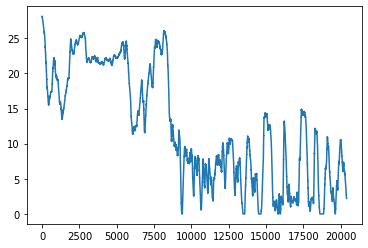

Labels are equal to number of frames


In [0]:
preprocessor = PreProcessor()
preprocessor.plot_training_speed(labels)
preprocessor.generate_images(train_video, labels)